#Data Extraction

In [4]:
!mkdir cop_data && unrar x /content/drive/MyDrive/Research/data.rar /content/cop_data



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/Research/data.rar

Creating    /content/cop_data/data                                    OK
Extracting  /content/cop_data/data/._100_proba_free_1.prn                  0%  OK 
Extracting  /content/cop_data/data/._100_proba_free_10.prn                 0%  OK 
Extracting  /content/cop_data/data/._100_proba_free_11.prn                 0%  OK 
Extracting  /content/cop_data/data/._100_proba_free_2.prn                  0%  OK 
Extracting  /content/cop_data/data/._100_proba_free_3.prn                  0%  OK 
Extracting  /content/cop_data/data/._100_proba_free_4.prn                  0%  OK 
Extracting  /content/cop_data/data/._100_proba_free_5.prn                  0%  OK 
Extracting  /content/cop_data/data/._100_proba_free_6.prn                  0%  OK 
Extracting  /content/cop_data/data/._100_proba_free_7.prn

#Setup and Libraries

In [5]:
# @title 1. Install & Import Libraries
!pip install EMD-signal
!pip install imbalanced-learn
!pip install pywavelets
!pip install pandas numpy scipy scikit-learn

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pywt
from PyEMD import EMD
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

print("Libraries ready.")

Libraries ready.


#Data Extraction Logic

Extract trial and feature level data from the .prn files

In [6]:
# @title 2. Data Extraction Logic (Fixed for UTF-16)
def parse_filename(filename):
    """
    Parses filename like '129_proba_free_7.prn'
    Returns: subject_id, condition, trial_num
    """
    name = os.path.splitext(filename)[0]
    parts = name.split('_')

    if len(parts) >= 4:
        subject_id = parts[0]
        condition = parts[2]
        trial_num = parts[-1]
        return subject_id, condition, trial_num
    else:
        return None, None, None

def load_prn_data(data_folder_path):
    all_data = []
    file_list = glob.glob(os.path.join(data_folder_path, "*.prn"))

    print(f"Found {len(file_list)} .prn files in {data_folder_path}")

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        subj, cond, trial = parse_filename(file_name)

        if subj is None:
            continue

        try:
            # FIXED: Added encoding='utf-16'
            # We also added sep='\t' (tab) which is standard for PRN
            try:
                df = pd.read_csv(file_path, sep='\t', skiprows=1, header=None, encoding='utf-16')
            except UnicodeError:
                # Fallback if standard utf-16 fails (rare)
                df = pd.read_csv(file_path, sep='\t', skiprows=1, header=None, encoding='utf-16-le')

            # Rename columns based on your structure
            # Ensure the file actually has 6 columns before renaming
            if df.shape[1] >= 6:
                df = df.iloc[:, :6] # Keep only first 6 columns
                df.columns = ['idx', 'meas_num', 'sample_num', 'mass', 'cop_x', 'cop_y']

                # Add metadata
                df['subject'] = subj
                df['condition'] = cond
                df['trial'] = trial
                df['file'] = file_name

                # Append relevant data
                all_data.append(df[['subject', 'condition', 'trial', 'file', 'mass', 'cop_x', 'cop_y']])
            else:
                print(f"Skipping {file_name}: Unexpected column count {df.shape[1]}")

        except Exception as e:
            print(f"Error reading {file_name}: {e}")

    if not all_data:
        return pd.DataFrame()

    return pd.concat(all_data, ignore_index=True)

# --- EXECUTION ---
DATA_FOLDER = '/content/cop_data/data'

if not os.path.exists(DATA_FOLDER):
    print(f"Folder {DATA_FOLDER} not found. Please create it and upload files.")
    signal_df = pd.DataFrame()
else:
    signal_df = load_prn_data(DATA_FOLDER)
    print(f"Successfully loaded signal_df with shape: {signal_df.shape}")
    if not signal_df.empty:
        print(signal_df.head())

Found 997 .prn files in /content/cop_data/data
Successfully loaded signal_df with shape: (8276763, 7)
  subject condition trial                 file       mass     cop_x      cop_y
0      77      free     3  77_proba_free_3.prn  51.088673  1.590360 -32.895939
1      77      free     3  77_proba_free_3.prn  51.095562  1.558467 -32.959023
2      77      free     3  77_proba_free_3.prn  51.102497  1.526855 -33.021317
3      77      free     3  77_proba_free_3.prn  51.109329  1.495487 -33.081474
4      77      free     3  77_proba_free_3.prn  51.115913  1.464316 -33.138172


In [16]:
# @title Optimized Feature Extraction (Parallel Processing with VGRF)
import pandas as pd
import numpy as np
import pywt
from scipy.signal import butter, filtfilt
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

# --- 1. Define Helper Functions (Same as before) ---

def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # Use axis=0 to handle 1D arrays correctly without errors
    y = filtfilt(b, a, data, axis=0)
    return y

def compute_sway_area(x, y):
    if len(x) < 2: return 0
    cov = np.cov(x, y)
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(np.abs(lambda_))
    return np.pi * lambda_[0] * lambda_[1] * 5.991

def compute_apen(u, m=2, r=0.2):
    N = len(u)
    # Optimization: Downsample large signals for Entropy calc
    if N > 1000: u = u[::5] # Downsample by 5

    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        N = len(u)
        x = [[u[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    return abs(_phi(m+1) - _phi(m))

def process_single_group(group_df):
    """Processes one trial (group) independently."""
    try:
        # Extract Raw Signals
        cop_x = group_df['cop_x'].values.astype(float)
        cop_y = group_df['cop_y'].values.astype(float)

        # Check if 'mass' exists (VGRF), otherwise default to 0s to prevent crash
        if 'mass' in group_df.columns:
            vgrf = group_df['mass'].values.astype(float)
        else:
            vgrf = np.zeros_like(cop_x)

        fs = 250

        # 1. Filter
        cop_x = butter_lowpass_filter(cop_x, 0.5, fs)
        cop_y = butter_lowpass_filter(cop_y, 0.5, fs)
        vgrf_filt = butter_lowpass_filter(vgrf, 2.0, fs)

        # 2. Time Domain Features
        dist = np.sqrt(np.diff(cop_x)**2 + np.diff(cop_y)**2)
        path_length = np.sum(dist)
        vel_rms = np.sqrt(np.mean((dist * fs)**2))
        area = compute_sway_area(cop_x, cop_y)

        # 3. VGRF Features (Force Variability)
        vgrf_std = np.std(vgrf_filt)
        vgrf_range = np.max(vgrf_filt) - np.min(vgrf_filt)
        vgrf_mean = np.mean(vgrf_filt)
        # Coefficient of Variation (handle divide by zero)
        vgrf_cov = vgrf_std / (vgrf_mean if abs(vgrf_mean) > 1e-6 else 1.0)

        # 4. Wavelets (Level 4 ~ 3-7Hz)
        coeffs_x = pywt.wavedec(cop_x, 'db4', level=4)
        if len(coeffs_x) > 4:
            energy_L4_x = np.sum(np.square(coeffs_x[4]))
        else:
            energy_L4_x = 0

        # 5. Entropy (ApEn) - Expensive computation
        # Use tolerance r = 0.2 * std of THIS trial
        apen_y = compute_apen(cop_y, m=2, r=0.2*np.std(cop_y))

        # Metadata
        meta = group_df.iloc[0]

        return {
            'subject': meta['subject'],
            'condition': meta['condition'],
            'trial': meta['trial'],
            'file': meta['file'],
            # Features
            'path_length': path_length,
            'vel_rms': vel_rms,
            'sway_area': area,
            'wavelet_energy_L4_x': energy_L4_x,
            'ApEn_y': apen_y,
            # VGRF Features
            'vgrf_std': vgrf_std,
            'vgrf_range': vgrf_range,
            'vgrf_cov': vgrf_cov,
            # Ablation Helpers
            'pl_x': np.sum(np.abs(np.diff(cop_x))),
            'pl_y': np.sum(np.abs(np.diff(cop_y))),
            'path_length_x': np.sum(np.abs(np.diff(cop_x))),
            'path_length_y': np.sum(np.abs(np.diff(cop_y)))
        }
    except Exception as e:
        # Return None so we can filter it out later
        return None

# --- 2. EXECUTE IN PARALLEL ---
print("Grouping data by file...")
# Create a list of groups (one per trial file)
# This avoids passing the huge dataframe to every core
grouped_data = [group for name, group in signal_df.groupby('file')]

print(f"Starting Parallel Processing of {len(grouped_data)} trials...")
print("This uses all CPU cores. Please wait...")

# Run Parallel Job
# n_jobs=-1 uses all available cores
results = Parallel(n_jobs=-1)(
    delayed(process_single_group)(group)
    for group in tqdm(grouped_data)
)

# Filter out failed trials (None)
valid_results = [r for r in results if r is not None]

# Create DataFrame
features_df = pd.DataFrame(valid_results)
features_df['binary_condition'] = features_df['condition'].apply(lambda x: 1 if x == 'stress' else 0)

print(f"✅ DONE! Processed {len(features_df)} trials.")
print(features_df[['file', 'path_length', 'vgrf_std']].head())

Grouping data by file...
Starting Parallel Processing of 997 trials...
This uses all CPU cores. Please wait...


  0%|          | 0/997 [00:00<?, ?it/s]

✅ DONE! Processed 997 trials.
                    file  path_length  vgrf_std
0   100_proba_free_1.prn   107.761878  0.032053
1  100_proba_free_10.prn    80.139257  0.020435
2  100_proba_free_11.prn   112.265607  0.023709
3   100_proba_free_2.prn   141.459737  0.043180
4   100_proba_free_3.prn   135.169782  0.033898


In [ ]:
features_df

✅ VGRF Features found: ['vgrf_std', 'vgrf_range', 'vgrf_cov']

TASK 1: CONDITION PREDICTION (Free vs Stress)
   Training models for: No VGRF...
   Training models for: With VGRF...


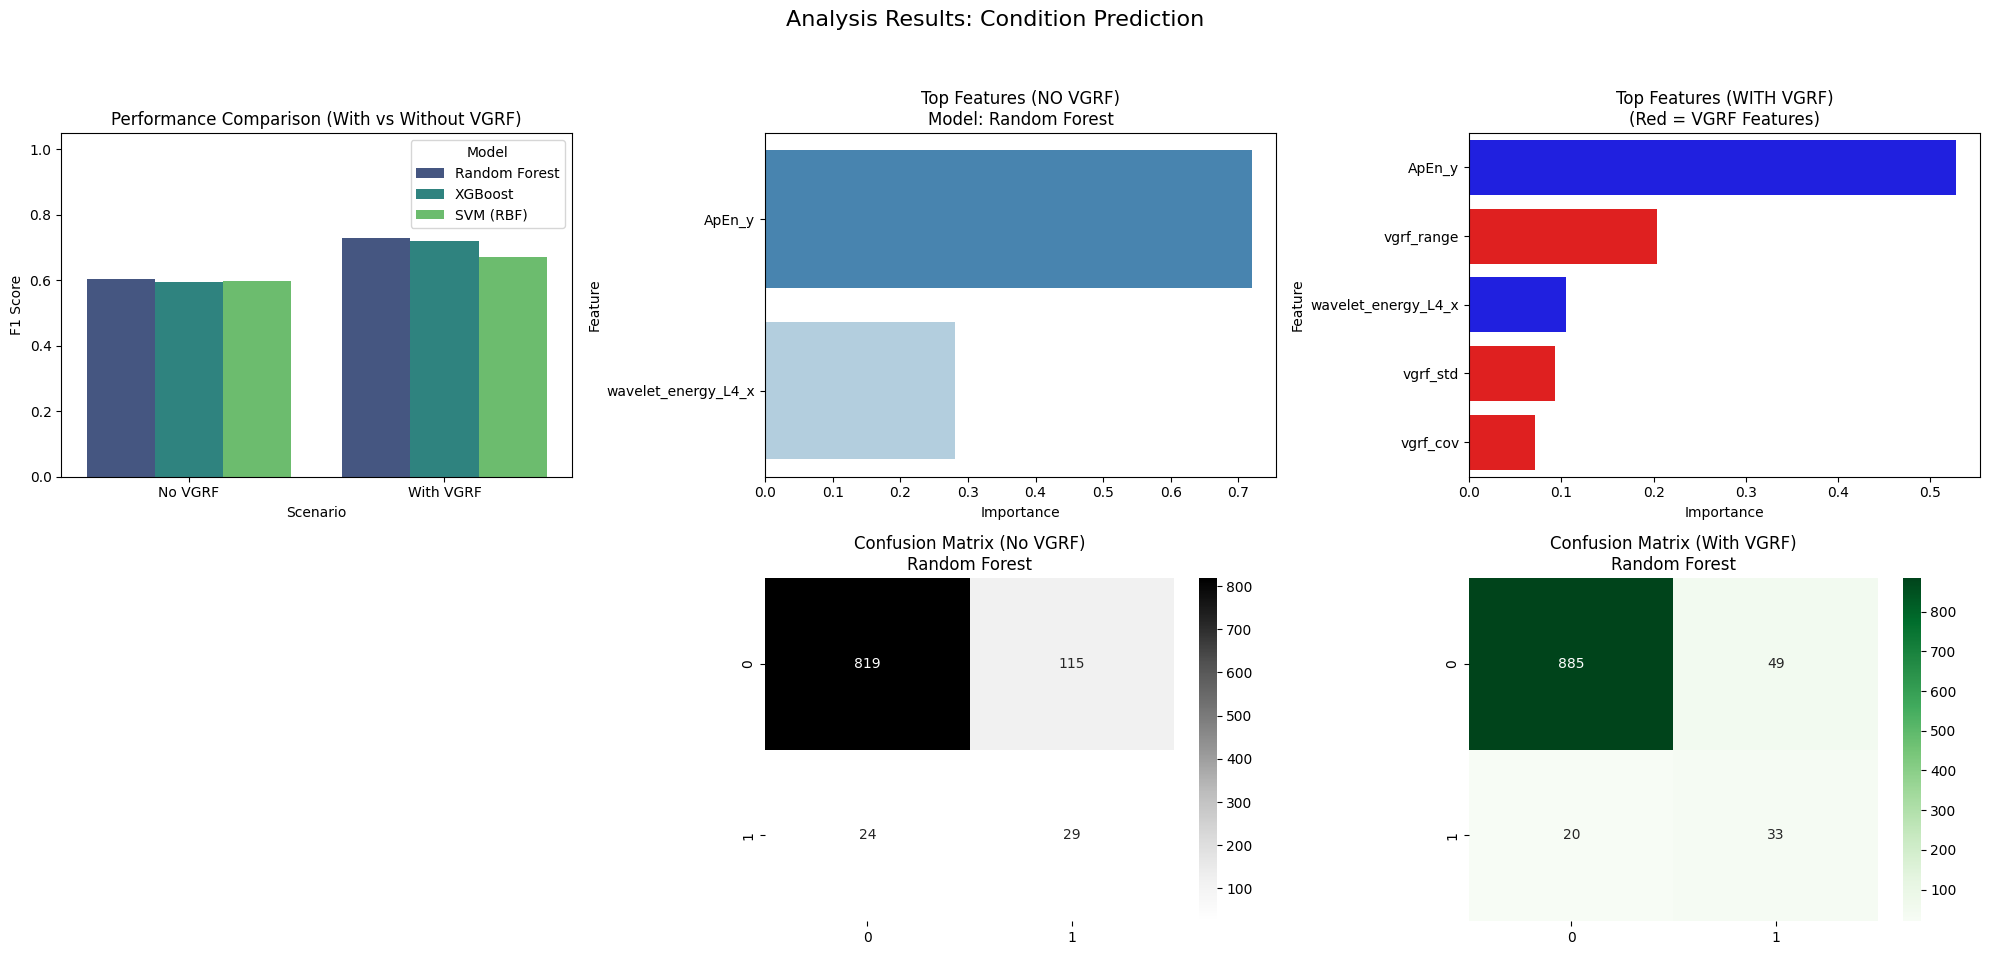


Results Summary (Condition):
 Scenario         Model  F1 Score  Sensitivity
With VGRF Random Forest  0.728009     0.618182
With VGRF       XGBoost  0.720715     0.605455
With VGRF     SVM (RBF)  0.671354     0.905455
  No VGRF Random Forest  0.604878     0.543636
  No VGRF     SVM (RBF)  0.597289     0.823636
  No VGRF       XGBoost  0.595945     0.525455

TASK 2: TRIAL PREDICTION (Early vs Late)
   Training models for: No VGRF...
   Training models for: With VGRF...


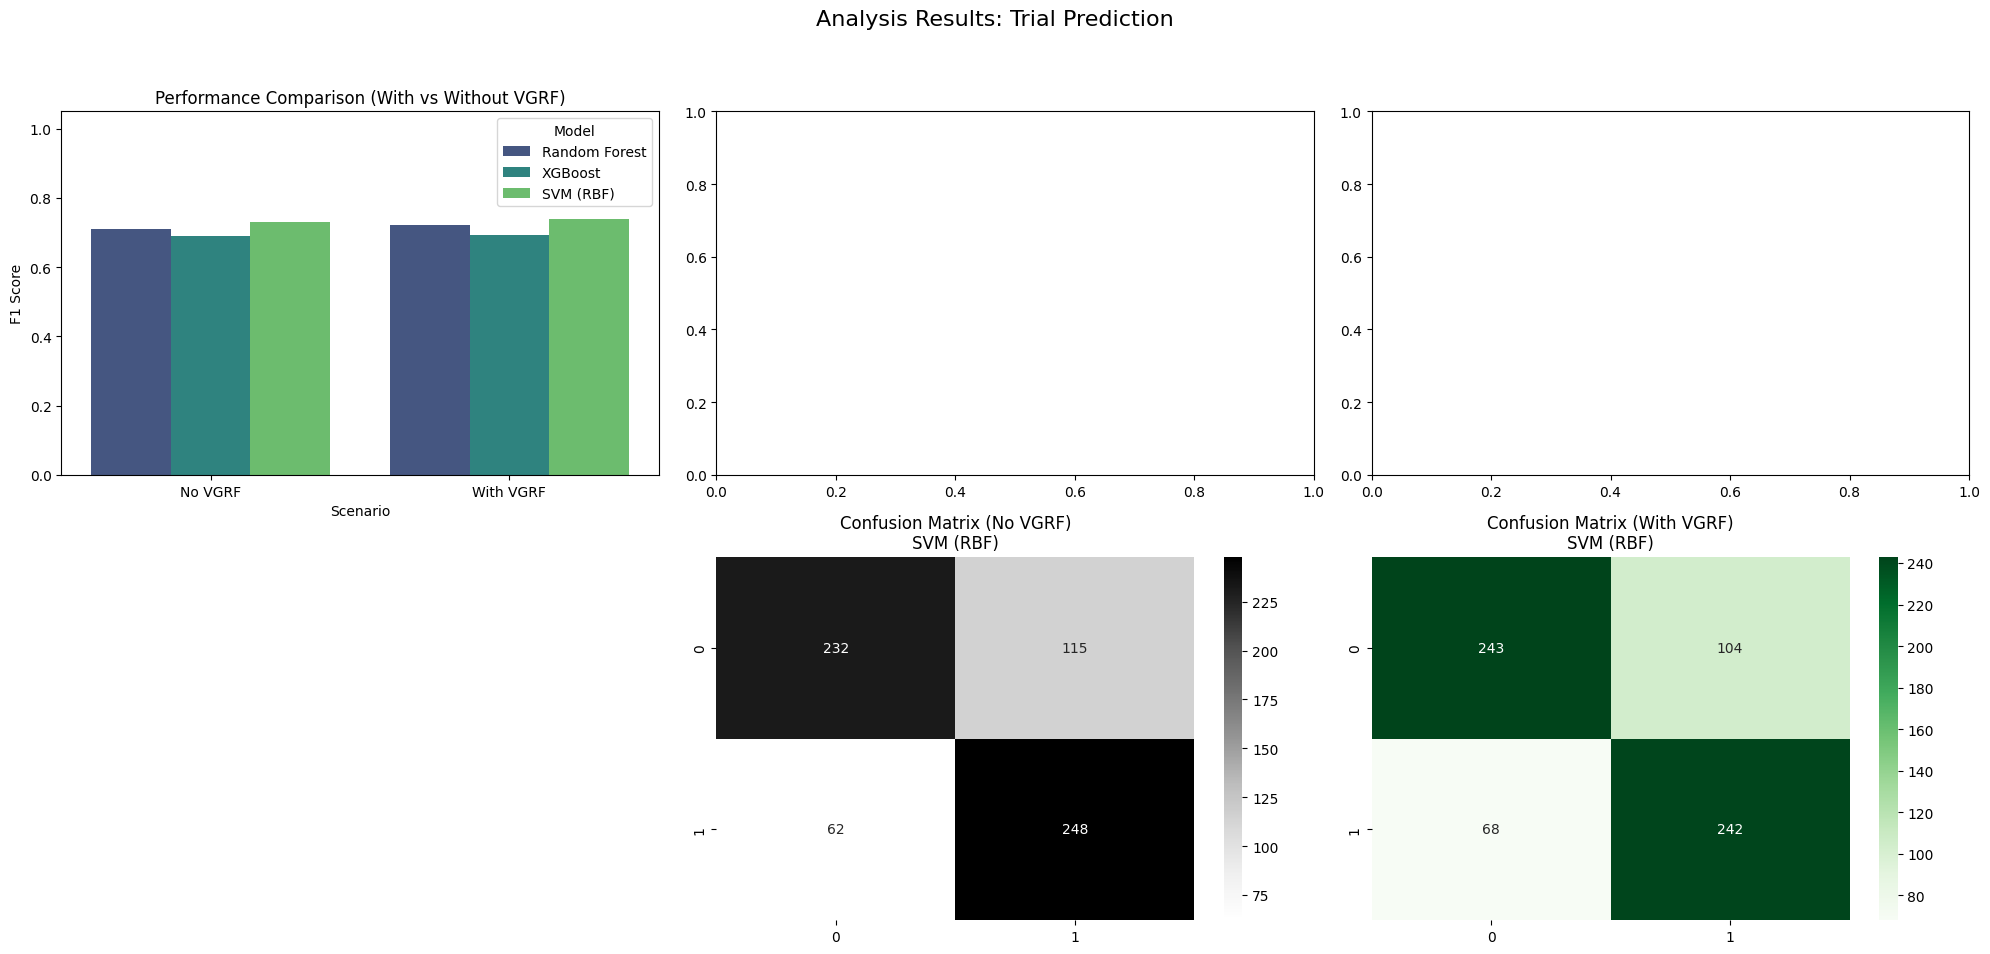


Results Summary (Trial):
 Scenario         Model  F1 Score  Accuracy
With VGRF     SVM (RBF)  0.737683  0.738292
  No VGRF     SVM (RBF)  0.729757  0.730657
With VGRF Random Forest  0.722496  0.722918
  No VGRF Random Forest  0.708959  0.709201
With VGRF       XGBoost  0.692601  0.694152
  No VGRF       XGBoost  0.690106  0.691017


In [20]:
# @title Complete Comparative Analysis (With vs. Without VGRF)
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedGroupKFold, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# --- CONFIGURATION ---
# Define Feature Groups
vgrf_cols = ['vgrf_std', 'vgrf_range', 'vgrf_cov', 'mass', 'vgrf_mean']
# Ablation: Amplitude features to remove for "Hard Mode" Condition Prediction
ablation_cols = ['path_length', 'vel_rms', 'sway_area', 'pl_x', 'pl_y', 'path_length_x', 'path_length_y']
meta_cols = ['subject', 'condition', 'trial', 'file', 'binary_condition', 'phase']

# Check availability
available_vgrf = [c for c in vgrf_cols if c in features_df.columns]
print(f"✅ VGRF Features found: {available_vgrf}")

# --- HELPER: Analysis Runner ---
def run_model_comparison(X, y, groups, title_suffix=""):
    """
    Runs RF, XGB, and SVM. Returns metrics and best model details for plotting.
    """
    models = {
        "Random Forest": ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
        ]),
        "XGBoost": ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('clf', XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))
        ]),
        "SVM (RBF)": ImbPipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('clf', SVC(kernel='rbf', probability=True, random_state=42))
        ])
    }

    cv = StratifiedGroupKFold(n_splits=5)
    results = []
    best_f1 = 0
    best_model_data = None

    print(f"   Training models for: {title_suffix}...")

    for name, pipe in models.items():
        # CV Training
        scores = cross_validate(pipe, X, y, groups=groups, cv=cv,
                                scoring=['accuracy', 'f1_macro', 'recall'])

        mean_f1 = np.mean(scores['test_f1_macro'])
        results.append({
            'Model': name,
            'Scenario': title_suffix,
            'Accuracy': np.mean(scores['test_accuracy']),
            'F1 Score': mean_f1,
            'Sensitivity': np.mean(scores['test_recall'])
        })

        # Check if this is the best model so far (for plotting later)
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            # Generate predictions for confusion matrix
            y_pred = cross_val_predict(pipe, X, y, groups=groups, cv=cv)
            # Train once on full data for feature importance
            pipe.fit(X, y)
            best_model_data = {
                'name': name,
                'pipeline': pipe,
                'y_pred': y_pred,
                'y_true': y
            }

    return pd.DataFrame(results), best_model_data

# --- HELPER: Plotting Suite ---
def plot_suite(results_df, best_data_no, best_data_with, feature_names_no, feature_names_with, task_title):
    """Generates the 2x2 visualization grid."""
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle(f"Analysis Results: {task_title}", fontsize=16)

    # 1. Performance Comparison (Bar Chart)
    sns.barplot(x='Scenario', y='F1 Score', hue='Model', data=results_df, ax=axes[0, 0], palette='viridis')
    axes[0, 0].set_title("Performance Comparison (With vs Without VGRF)")
    axes[0, 0].set_ylim(0, 1.05)

    # 2. Feature Importance (Without VGRF) - Best Model
    if hasattr(best_data_no['pipeline'].named_steps['clf'], 'feature_importances_'):
        imps = best_data_no['pipeline'].named_steps['clf'].feature_importances_
        feat_df = pd.DataFrame({'Feature': feature_names_no, 'Importance': imps}).sort_values('Importance', ascending=False).head(10)
        sns.barplot(x='Importance', y='Feature', data=feat_df, ax=axes[0, 1], palette='Blues_r')
        axes[0, 1].set_title(f"Top Features (NO VGRF)\nModel: {best_data_no['name']}")

    # 3. Feature Importance (With VGRF) - Best Model
    if hasattr(best_data_with['pipeline'].named_steps['clf'], 'feature_importances_'):
        imps = best_data_with['pipeline'].named_steps['clf'].feature_importances_
        feat_df = pd.DataFrame({'Feature': feature_names_with, 'Importance': imps}).sort_values('Importance', ascending=False).head(10)
        # Highlight VGRF features in color
        clrs = ['red' if 'vgrf' in x else 'blue' for x in feat_df['Feature']]
        sns.barplot(x='Importance', y='Feature', data=feat_df, ax=axes[0, 2], palette=clrs)
        axes[0, 2].set_title(f"Top Features (WITH VGRF)\n(Red = VGRF Features)")

    # 4. Confusion Matrix (Without VGRF)
    cm_no = confusion_matrix(best_data_no['y_true'], best_data_no['y_pred'])
    sns.heatmap(cm_no, annot=True, fmt='d', cmap='Greys', ax=axes[1, 1])
    axes[1, 1].set_title(f"Confusion Matrix (No VGRF)\n{best_data_no['name']}")

    # 5. Confusion Matrix (With VGRF)
    cm_with = confusion_matrix(best_data_with['y_true'], best_data_with['y_pred'])
    sns.heatmap(cm_with, annot=True, fmt='d', cmap='Greens', ax=axes[1, 2])
    axes[1, 2].set_title(f"Confusion Matrix (With VGRF)\n{best_data_with['name']}")

    # Empty plot for layout
    axes[1, 0].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==============================================================================
# EXPERIMENT 1: CONDITION PREDICTION (Ablation Study)
# ==============================================================================
print("\n" + "="*80)
print("TASK 1: CONDITION PREDICTION (Free vs Stress)")
print("="*80)

# Prepare Data
cond_df = features_df[features_df['condition'].isin(['free', 'stress'])].copy()
y_cond = LabelEncoder().fit_transform(cond_df['condition'])
groups_cond = cond_df['subject']

# Scenario A: NO VGRF (Drop VGRF + Amplitude)
cols_no_vgrf = meta_cols + ablation_cols + vgrf_cols
X_cond_no = cond_df.drop([c for c in cols_no_vgrf if c in cond_df.columns], axis=1)

# Scenario B: WITH VGRF (Drop Amplitude ONLY)
cols_with_vgrf = meta_cols + ablation_cols
X_cond_with = cond_df.drop([c for c in cols_with_vgrf if c in cond_df.columns], axis=1)

# Run Comparisons
res_cond_no, best_cond_no = run_model_comparison(X_cond_no, y_cond, groups_cond, "No VGRF")
res_cond_with, best_cond_with = run_model_comparison(X_cond_with, y_cond, groups_cond, "With VGRF")

# Combine & Plot
all_res_cond = pd.concat([res_cond_no, res_cond_with])
plot_suite(all_res_cond, best_cond_no, best_cond_with, X_cond_no.columns, X_cond_with.columns, "Condition Prediction")

print("\nResults Summary (Condition):")
print(all_res_cond[['Scenario', 'Model', 'F1 Score', 'Sensitivity']].sort_values('F1 Score', ascending=False).to_string(index=False))


# ==============================================================================
# EXPERIMENT 2: TRIAL PREDICTION (Fatigue/Learning)
# ==============================================================================
print("\n" + "="*80)
print("TASK 2: TRIAL PREDICTION (Early vs Late)")
print("="*80)

# Prepare Data (Subject-Specific Normalization)
time_df = features_df.copy()
time_df['trial'] = pd.to_numeric(time_df['trial'], errors='coerce')

# Normalize
num_cols = time_df.select_dtypes(include=[np.number]).columns
cols_to_norm = [c for c in num_cols if c not in meta_cols] # Normalize VGRF too if present
for col in cols_to_norm:
    time_df[col] = time_df.groupby('subject')[col].transform(lambda x: (x - x.mean()) / (x.std() + 1e-6))
time_df[cols_to_norm] = time_df[cols_to_norm].fillna(0)

# Define Classes
def get_phase(t): return 'Early' if t >= 8 else ('Late' if t <= 3 else 'Drop')
time_df['phase'] = time_df['trial'].apply(get_phase)
binary_time = time_df[time_df['phase'] != 'Drop'].copy()
y_time = LabelEncoder().fit_transform(binary_time['phase'])
groups_time = binary_time['subject']

# Scenario A: NO VGRF
drop_time_A = meta_cols + vgrf_cols
X_time_no = binary_time.drop([c for c in drop_time_A if c in binary_time.columns], axis=1)

# Scenario B: WITH VGRF
drop_time_B = meta_cols
X_time_with = binary_time.drop([c for c in drop_time_B if c in binary_time.columns], axis=1)

# Run Comparisons
res_time_no, best_time_no = run_model_comparison(X_time_no, y_time, groups_time, "No VGRF")
res_time_with, best_time_with = run_model_comparison(X_time_with, y_time, groups_time, "With VGRF")

# Combine & Plot
all_res_time = pd.concat([res_time_no, res_time_with])
plot_suite(all_res_time, best_time_no, best_time_with, X_time_no.columns, X_time_with.columns, "Trial Prediction")

print("\nResults Summary (Trial):")
print(all_res_time[['Scenario', 'Model', 'F1 Score', 'Accuracy']].sort_values('F1 Score', ascending=False).to_string(index=False))

In [ ]:
# @title Pipeline 2: Trial Prediction (Early vs. Late)
# --- 1. DATA PREPARATION (Normalization) ---
time_df = features_df.copy()
time_df['trial'] = pd.to_numeric(time_df['trial'], errors='coerce')

# Robust Z-Score Function (Per Subject)
def robust_zscore(x):
    if len(x) < 2 or x.std() == 0: return np.zeros(len(x))
    return (x - x.mean()) / x.std()

# Normalize numeric columns
num_cols = time_df.select_dtypes(include=[np.number]).columns
meta_cols = ['subject', 'trial', 'condition', 'file', 'binary_condition', 'phase']
norm_cols = [c for c in num_cols if c not in meta_cols]

for col in norm_cols:
    time_df[col] = time_df.groupby('subject')[col].transform(robust_zscore)
time_df[norm_cols] = time_df[norm_cols].fillna(0)

# Define Early/Late
def get_phase(t):
    if t >= 8: return 'Early'
    elif t <= 3: return 'Late'
    else: return 'Drop'

time_df['phase'] = time_df['trial'].apply(get_phase)
binary_time = time_df[time_df['phase'] != 'Drop'].copy()

# Setup Targets
y_time = LabelEncoder().fit_transform(binary_time['phase']) # 0=Early, 1=Late
groups_time = binary_time['subject']
X_time = binary_time.drop(meta_cols + ['phase'], axis=1, errors='ignore')

# --- 2. ANOVA SELECTION ---
print("\n--- Selecting Temporal Features (ANOVA) ---")
selector_time = SelectKBest(f_classif, k=10)
X_time_selected = selector_time.fit_transform(X_time, y_time)
selected_feats_time = X_time.columns[selector_time.get_support()]
print(f"Selected: {list(selected_feats_time)}")

# --- 3. DEFINE MODELS ---
models_time = {
    "Random Forest": ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))
    ]),
    "XGBoost": ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))
    ]),
    "SVM (RBF)": ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', SVC(kernel='rbf', C=1.0, random_state=42))
    ])
}

# --- 4. EVALUATION LOOP ---
cv_time = StratifiedGroupKFold(n_splits=5)
results_time = []

print("\n--- Training Temporal Models ---")
for name, pipe in models_time.items():
    scores = cross_validate(pipe, X_time_selected, y_time, groups=groups_time, cv=cv_time,
                            scoring=['accuracy', 'f1_macro'])

    results_time.append({
        'Model': name,
        'Accuracy': np.mean(scores['test_accuracy']),
        'F1 Score': np.mean(scores['test_f1_macro'])
    })
    print(f"{name:<15} | Acc: {np.mean(scores['test_accuracy']):.3f} | F1: {np.mean(scores['test_f1_macro']):.3f}")

# --- 5. VISUALIZATION ---
res_time_df = pd.DataFrame(results_time).sort_values('F1 Score', ascending=False)
best_time_model = res_time_df.iloc[0]['Model']

plt.figure(figsize=(18, 5))

# Plot A: Model Comparison
plt.subplot(1, 3, 1)
sns.barplot(x='F1 Score', y='Model', data=res_time_df, palette='Purples')
plt.title("Model Comparison (Temporal)")
plt.xlim(0.4, 0.9) # Zoom in to see differences

# Plot B: Trend of Top Feature
plt.subplot(1, 3, 2)
# Re-calculate ANOVA scores for plotting
f_scores_time = selector_time.scores_[selector_time.get_support()]
feat_time_df = pd.DataFrame({'Feature': selected_feats_time, 'F_Score': f_scores_time}).sort_values('F_Score', ascending=False)
top_feat = feat_time_df.iloc[0]['Feature']

sns.boxplot(x='phase', y=top_feat, data=binary_time, order=['Early', 'Late'], palette='coolwarm')
plt.title(f"Trend: {top_feat} (Subject Z-Score)")
plt.ylabel("Deviation from Mean")

# Plot C: Statistical Significance (Best vs Dummy)
plt.subplot(1, 3, 3)
# Get scores for Best Model
best_scores = cross_val_score(models_time[best_time_model], X_time_selected, y_time, groups=groups_time, cv=cv_time, scoring='f1_macro')
# Get scores for Dummy
dummy_scores = cross_val_score(DummyClassifier(strategy='most_frequent'), X_time_selected, y_time, groups=groups_time, cv=cv_time, scoring='f1_macro')

t_stat, p_val = stats.ttest_rel(best_scores, dummy_scores)

plot_sig = pd.DataFrame({
    'Model': [best_time_model]*5 + ['Baseline']*5,
    'F1 Score': np.concatenate([best_scores, dummy_scores])
})
sns.boxplot(x='Model', y='F1 Score', data=plot_sig, palette='Set2')
plt.title(f"Significance: p={p_val:.2e}")

plt.tight_layout()
plt.show()

print("\nBest Temporal Model Results:")
print(res_time_df.iloc[0])